# GLM: Logistic Regression

* This is a reproduction with a few slight alterations of [Bayesian Log Reg](http://jbencook.github.io/portfolio/bayesian_logistic_regression.html) by J. Benjamin Cook

* Author: Peadar Coyle and J. Benjamin Cook
* How likely am I to make more than $50,000 US Dollars?
* Exploration of model selection techniques too - I use DIC and WAIC to select the best model. 
* The convenience functions are all taken from Jon Sedars work.
* This example also has some explorations of the features so serves as a good example of Exploratory Data Analysis and how that can guide the model creation/ model selection process. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T 


In [26]:
def run_models(df, upper_order=5):
    ''' 
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity. 
    Suggest limit to max order 5 since calculation time is exponential.
    '''
    
    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Normal())

            traces[nm] = pm.sample(2000, init=None) 
            
    return models, traces

def plot_traces(traces, retain=1000):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''
    
    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
def create_poly_modelspec(k=1):
    ''' 
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j) 
                                     for j in range(2,k+1)])).strip()

The [Adult Data Set](http://archive.ics.uci.edu/ml/datasets/Adult) is commonly used to benchmark machine learning algorithms. The goal is to use demographic features, or variables, to predict whether an individual makes more than \\$50,000 per year. The data set is almost 20 years old, and therefore, not perfect for determining the probability that I will make more than \$50K, but it is a nice, simple dataset that can be used to showcase a few benefits of using Bayesian logistic regression over its frequentist counterpart.


The motivation for myself to reproduce this piece of work was to learn how to use Odd Ratio in Bayesian Regression.

In [3]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None, names=['age', 'workclass', 'fnlwgt', 
                'education-categorical', 'educ', 
                'marital-status', 'occupation',
                'relationship', 'race', 'sex', 
                'captial-gain', 'capital-loss', 
                'hours', 'native-country', 
                'income'])

In [4]:
data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Scrubbing and cleaning
We need to remove any null entries in Income. 
And we also want to restrict this study to the United States.

In [5]:
data = data[~pd.isnull(data['income'])]


In [6]:
data[data['native-country']==" United-States"]

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
12,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K


In [7]:
income = 1 * (data['income'] == " >50K")
age2 = np.square(data['age'])

In [8]:
data = data[['age', 'educ', 'hours']]
data['age2'] = age2
data['income'] = income

In [9]:
income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

## Exploring the data 
Let us get a feel for the parameters. 
* We see that age is a tailed distribution. Certainly not Gaussian!
* We don't see much of a correlation between many of the features, with the exception of Age and Age2. 
* Hours worked has some interesting behaviour. How would one describe this distribution? 


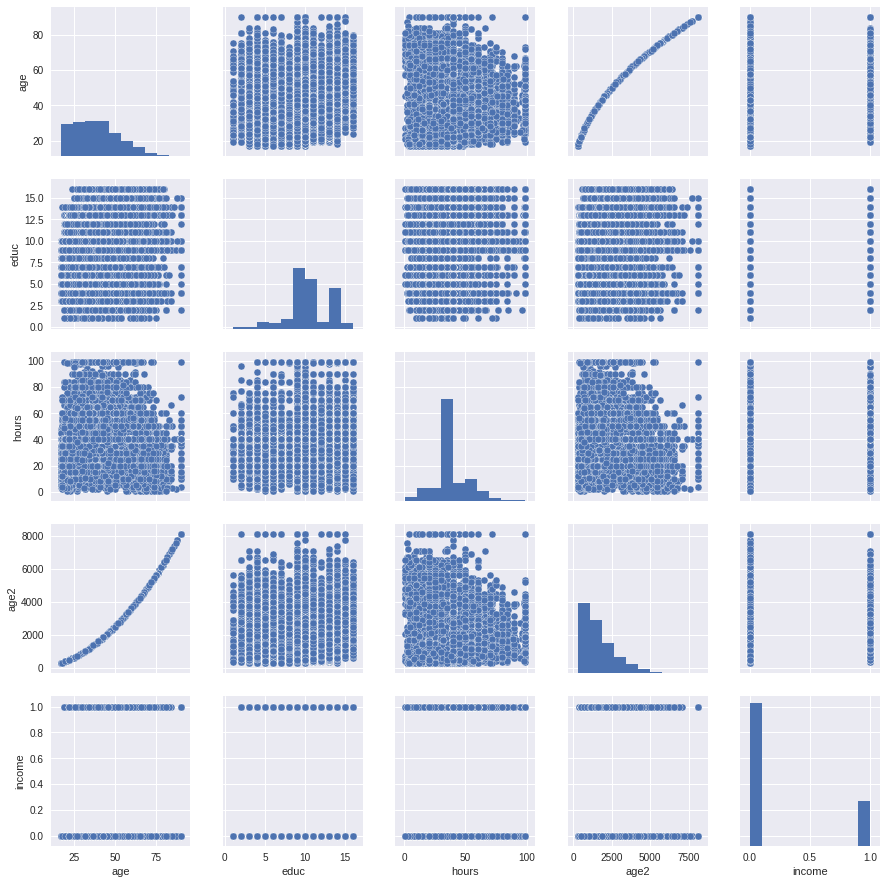

In [10]:
g = seaborn.pairplot(data)

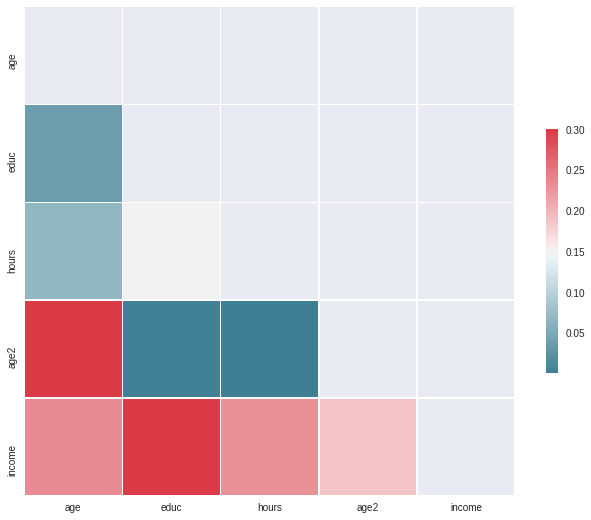

In [11]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

We see here not many strong correlations. The highest is 0.30 according to this plot. We see a weak-correlation between hours and income 
(which is logical), we see a slighty stronger correlation between education and income (which is the kind of question we are answering).

## The model
We will use a simple model, which assumes that the probability of making more than $50K 
is a function of age, years of education and hours worked per week. We will use PyMC3 
do inference. 

In Bayesian statistics, we treat everything as a random variable and we want to know the posterior probability distribution of the parameters
(in this case the regression coefficients)
The posterior is equal to the likelihood $$p(\theta | D) = \frac{p(D|\theta)p(\theta)}{p(D)}$$

Because the denominator is a notoriously difficult integral, $p(D) = \int p(D | \theta) p(\theta) d \theta $ we would prefer to skip computing it. Fortunately, if we draw examples from the parameter space, with probability proportional to the height of the posterior at any given point, we end up with an empirical distribution that converges to the posterior as the number of samples approaches infinity.  

What this means in practice is that we only need to worry about the numerator. 

Getting back to logistic regression, we need to specify a prior and a likelihood in order to draw samples from the posterior. We could use sociological knowledge about the effects of age and education on income, but instead, let's use the default prior specification for GLM coefficients that PyMC3 gives us, which is $p(θ)=N(0,10^{12}I)$. This is a very vague prior that will let the data speak for themselves.

The likelihood is the product of n Bernoulli trials, $\prod^{n}_{i=1} p_{i}^{y} (1 - p_{i})^{1-y_{i}}$,
where $p_i = \frac{1}{1 + e^{-z_i}}$, 

$z_{i} = \beta_{0} + \beta_{1}(age)_{i} + \beta_2(age)^{2}_{i} + \beta_{3}(educ)_{i} + \beta_{4}(hours)_{i}$ and $y_{i} = 1$ if income is greater than 50K and $y_{i} = 0$ otherwise. 

With the math out of the way we can get back to the data. Here I use PyMC3 to draw samples from the posterior. The sampling algorithm used is NUTS, which is a form of Hamiltonian Monte Carlo, in which parameteres are tuned automatically. Notice, that we get to borrow the syntax of specifying GLM's from R, very convenient! I use a convenience function from above to plot the trace infromation from the first 1000 parameters. 

In [13]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + age2 + educ + hours', data, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(4000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 18,443:  27%|██▋       | 53098/200000 [06:10<23:38, 103.58it/s]    
Convergence archived at 53100
Interrupted at 53,100 [26%]: Average Loss = 1.3951e+06
100%|██████████| 4500/4500 [29:39<00:00,  2.53it/s] 


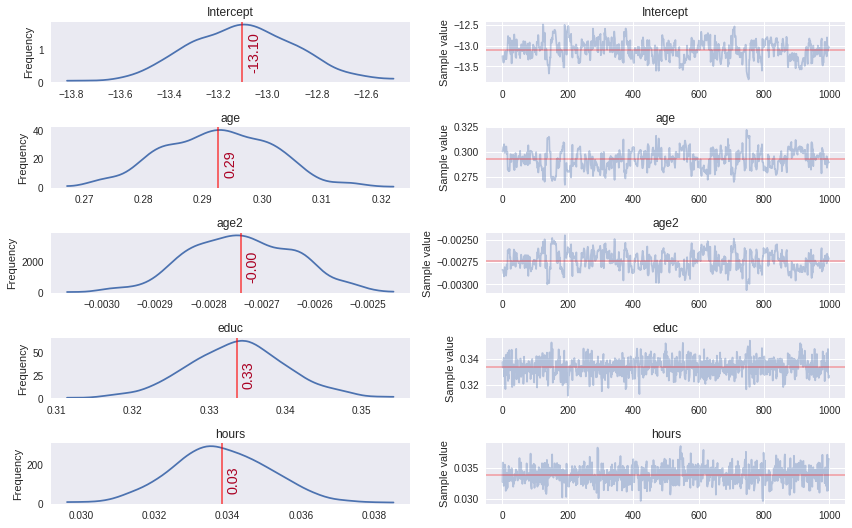

In [14]:
plot_traces(trace_logistic_model, retain=1000)

## Some results 
One of the major benefits that makes Bayesian data analysis worth the extra computational effort in many circumstances is that we can be explicit about our uncertainty. Maximum likelihood returns a number, but how certain can we be that we found the right number? Instead, Bayesian inference returns a distribution over parameter values.

I'll use seaborn to look at the distribution of some of these factors. 

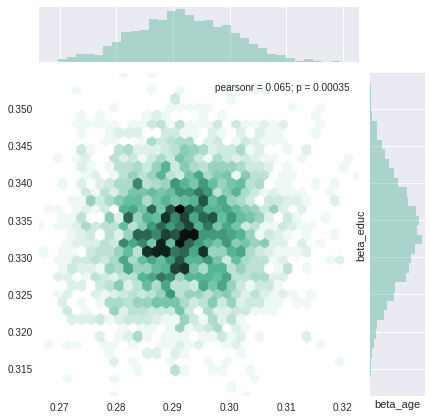

In [15]:
plt.figure(figsize=(9,7))
trace = trace_logistic_model[1000:]
seaborn.jointplot(trace['age'], trace['educ'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ")
plt.show()

So how do age and education affect the probability of making more than $$50K?$ To answer this question, we can show how the probability of making more than $50K changes with age for a few different education levels. Here, we assume that the number of hours worked per week is fixed at 50. PyMC3 gives us a convenient way to plot the posterior predictive distribution. We need to give the function a linear model and a set of points to evaluate. We will pass in three different linear models: one with educ == 12 (finished high school), one with educ == 16 (finished undergrad) and one with educ == 19 (three years of grad school).

In [16]:
# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*12 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*16 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*19 + 
                                          samples['hours']*50)))


Each curve shows how the probability of earning more than $ 50K$ changes with age. The red curve represents 19 years of education, the green curve represents 16 years of education and the blue curve represents 12 years of education. For all three education levels, the probability of making more than $50K increases with age until approximately age 60, when the probability begins to drop off. Notice that each curve is a little blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. Because the curves are somewhat translucent, we can interpret dark, narrow portions of a curve as places where we have low uncertainty and light, spread out portions of the curve as places where we have somewhat higher uncertainty about our coefficient values.

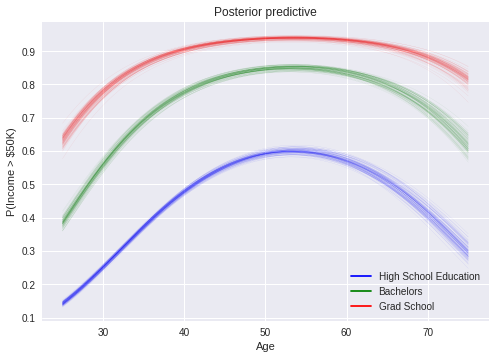

In [17]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

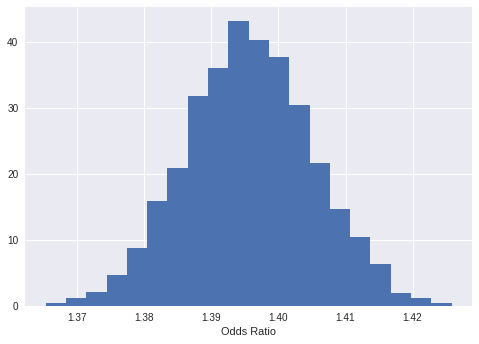

In [18]:
b = trace['educ']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()


Finally, we can find a credible interval (remember kids - credible intervals are Bayesian and confidence intervals are frequentist) for this quantity. This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we've always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [19]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < O.R. < %.3f) = 0.95"%(np.exp(3*lb),np.exp(3*ub)))

P(2.612 < O.R. < 2.829) = 0.95


## Model selection 
The [Deviance Information Criterion (DIC)](https://en.wikipedia.org/wiki/Deviance_information_criterion) is a fairly unsophisticated method for comparing the deviance of likelhood across the the sample traces of a model run. However, this simplicity apparently yields quite good results in a variety of cases. We'll run the model with a few changes to see what effect higher order terms have on this model.

One question that was immediately asked was what effect does age have on the model, and why should it be age^2 versus age? We'll use the DIC to answer this question. 

In [27]:
models_lin, traces_lin = run_models(data, 4)

Assigned NUTS to Intercept
Assigned NUTS to educ
Assigned NUTS to hours
Assigned NUTS to age
Assigned NUTS to sd_log__



Running: k1


100%|██████████| 2500/2500 [00:35<00:00, 70.76it/s]
Assigned NUTS to Intercept
Assigned NUTS to educ
Assigned NUTS to hours
Assigned NUTS to age
Assigned NUTS to np.power(age, 2)
Assigned NUTS to sd_log__



Running: k2


100%|██████████| 2500/2500 [01:15<00:00, 33.11it/s]
Assigned NUTS to Intercept
Assigned NUTS to educ
Assigned NUTS to hours
Assigned NUTS to age
Assigned NUTS to np.power(age, 2)
Assigned NUTS to np.power(age, 3)
Assigned NUTS to sd_log__



Running: k3


100%|██████████| 2500/2500 [03:19<00:00, 12.51it/s]
Assigned NUTS to Intercept
Assigned NUTS to educ
Assigned NUTS to hours
Assigned NUTS to age
Assigned NUTS to np.power(age, 2)
Assigned NUTS to np.power(age, 3)
Assigned NUTS to np.power(age, 4)
Assigned NUTS to sd_log__



Running: k4


100%|██████████| 2500/2500 [21:35<00:00,  2.28it/s]


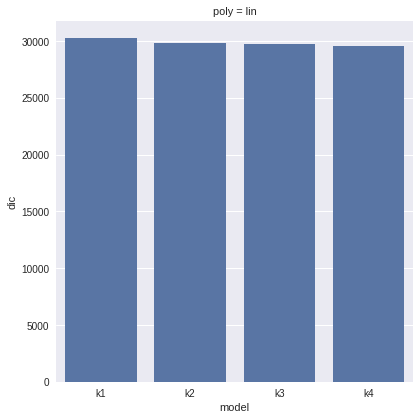

In [28]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.dic(traces_lin[nm], models_lin[nm])


dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='dic')

g = seaborn.factorplot(x='model', y='dic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)

There isn't a lot of difference between these models in terms of DIC. So our choice is fine in the model above, and there isn't much to be gained for going up to age^3 for example.
Next we look at [WAIC](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/dicwaic.html). Which is another model selection technique.

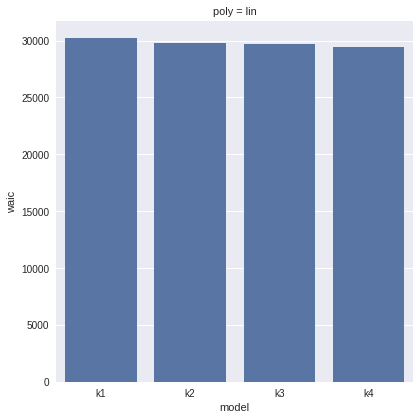

In [29]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.waic(traces_lin[nm],models_lin[nm])[0]


dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='waic')

g = seaborn.factorplot(x='model', y='waic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)

The WAIC confirms our decision to use age^2. 